In [1]:
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

from tqdm import tqdm
tqdm.pandas()

#sys.path.append('C:/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/Code/')
#sys.path.append('../code')
from quantum_kernel.code.utils import compute_additional_fields

In [2]:
def aggregate_pickles(all_pickles_paths, dataset_name):
    all_res = []
    
    for fname in all_pickles_paths:
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all = compute_additional_fields(df_all, dataset_name=dataset_name)
    df_all.drop(columns=['qkern_matrix_train', 'qkern_matrix_test'], inplace=True)
    return df_all

In [21]:
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/plasticc/","plasticc"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/fashion-mnist/","fashion-mnist"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/kmnist/","kmnist")
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    print(label)
    if "Sparse_IQP" in folder:
        prefix = "Sparse_IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    dfs[label] = dfs[label][dfs[label]['dataset_dim'] <= 22] 
    if "Sparse_IQP" in folder:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim']
    else:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim'] + 1

plasticc
For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/plasticc/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/plasticc/aggregated.p
fashion-mnist
For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/fashion-mnist/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/fashion-mnist/aggregated.p
kmnist
For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/kmnist/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/kmnist/aggregated.p


In [22]:
label2dataset = {Path(x).stem : y for x,y in folders}
label2dataset['IQP'] = 'plasticc'
label2dataset['control_evo_time'] = 'plasticc'

pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy',
    'evo_time' : 'Scaling factor',
    'scaling_factor' : 'Scaling factor',
    'log_scaling_factor' : 'Log10 Scaling Factor'
}

palette = sns.color_palette("viridis",23)
legend_elements = []

def plot_one_score(df, ax, metric_to_plot, x_axis_metric, legend=False,dims=None):
    """
    Plot one
    """
    #dims=list(sorted(set(df['Number of qubits'])))
    dims=[dims]
    densities=list(sorted(set(df['density'])))
    for idx2, dim in enumerate(dims):
        for idx3, density in enumerate(densities):
            to_plot = df[
                (df['Number of qubits'] == dim) & (df['density'] == density
                )
            ]
            x = sorted(set(to_plot[x_axis_metric]))
            x = [ii for ii in x if ii <= 1]
            y = [to_plot[
                to_plot[x_axis_metric] == evo_time
            ][metric_to_plot].mean() for evo_time in x]
            lp = ax.plot(
                x,y,
                label=str(density), 
                color=palette[density]
            )
            if legend:
                legend_elements.append(lp[0])
    #ax.set_xscale("log")    
    ax.set_xlabel(pretty_print_dict[x_axis_metric], fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    # Shrink current axis's height by 20% on the top
    box = ax.get_position()
    ax.set_position([box.x0, box.y0+0.025 * box.height,
                     box.width, box.height * 0.7])
def plot_scores_Sparse_IQP(dfs, metric_to_plot,dims):
    """
    Plot test score for Sparse_IQP
    """
    labels = ['fashion-mnist', 'kmnist', 'plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        plot_one_score(dfs[label], ax[idx], metric_to_plot, 'log_scaling_factor', legend = idx==0,dims=dims)
        #ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}", fontsize=12)
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot], fontsize=12)
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
        ax[idx].set_title(label)
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')

    ax[1].legend(
        handles=legend_elements[:]+[lp_r],
        title='Number of two qubit connections per qubit per layer',
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.4), 
        ncol=11, 
        labelspacing=0.1,
        columnspacing=1,
    )
    f.suptitle('Sparse IQP',fontsize=16)


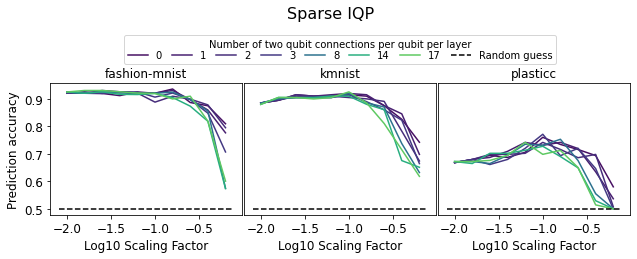

In [23]:
plot_scores_Sparse_IQP(dfs,'test_score',dims=18)
plt.savefig('/mnt/c/Users/lslat/Data/QK_project/figs/Sparse_IQP_test_accuracy.pdf')

In [24]:
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/plasticc/","plasticc"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/fashion-mnist/","fashion-mnist"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/kmnist/","kmnist")
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    print(label)
    if "Sparse_IQP" in folder:
        prefix = "Sparse_IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    dfs[label] = dfs[label][dfs[label]['dataset_dim'] <= 22] 
    if "Sparse_IQP" in folder:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim']
    else:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim'] + 1

plasticc
For /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/plasticc/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/plasticc/aggregated.p
fashion-mnist
For /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/fashion-mnist/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/fashion-mnist/aggregated.p
kmnist
For /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/kmnist/, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Heisenberg1D/kmnist/aggregated.p


In [25]:
pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy',
    'evo_time' : 'Scaling factor',
    'scaling_factor' : 'Scaling factor',
    'log_scaling_factor' : 'Log10 Scaling Factor'
}

palette = sns.color_palette("viridis",23)
legend_elements = []


def plot_one_score2(df, ax, metric_to_plot, x_axis_metric, legend=False,dims=None,r=0):
    """
    Plot one
    """
    #dims=list(sorted(set(df['Number of qubits'])))
    ks=list(sorted(set(df['k'])))
    for idx3, k in enumerate(ks):
        to_plot = df[
            (df['Number of qubits'] == dims) & (df['k'] == k
            ) & (df['r']==r)
        ]
        x = sorted(set(to_plot[x_axis_metric]))
        x = [ii for ii in x if ii <= 20]
        y = [to_plot[
            to_plot[x_axis_metric] == evo_time
        ][metric_to_plot].mean() for evo_time in x]
        x = [(2/df['n_trotter'])*ii for ii in x]
        lp = ax.plot(
            x,y,
            label=str(k), 
            color=palette[3*k]
        )
        if legend:
            legend_elements.append(lp[0])
    ax.set_xscale("log")    
    ax.set_xlabel(pretty_print_dict[x_axis_metric], fontsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    # Shrink current axis's height by 20% on the top
    box = ax.get_position()
    ax.set_position([box.x0, box.y0+0.025 * box.height,
                     box.width, box.height * 0.7])

def plot_scores_Heisenberg1D(dfs, metric_to_plot,dims,r=0):
    """
    Plot test score for Heisenberg1D
    """
    labels = ['fashion-mnist', 'kmnist', 'plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        plot_one_score2(dfs[label], ax[idx], metric_to_plot, 'evo_time', legend = idx==0,dims=dims,r=0)
        #ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}", fontsize=12)
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot], fontsize=12)
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
        ax[idx].set_title(label)
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')

    ax[1].legend(
        handles=legend_elements[:]+[lp_r],
        title='K (interaction range)',
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.4), 
        ncol=4, 
        labelspacing=0.1,
        columnspacing=1,
    )
    f.suptitle('Heisenberg1D',fontsize=16)


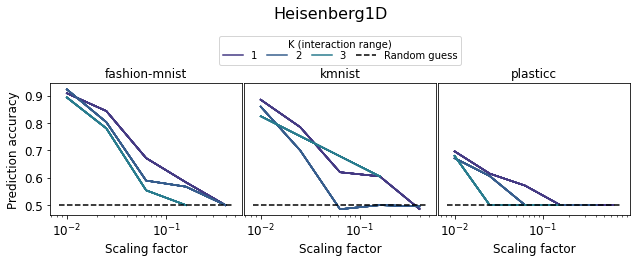

In [26]:
plot_scores_Heisenberg1D(dfs,'test_score',dims=18)
plt.savefig('/mnt/c/Users/lslat/Data/QK_project/figs/Heisenberg1D_test_accuracy.pdf')

In [27]:
dfs = {}

folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/","plasticc"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/fashion-mnist/","fashion-mnist"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/kmnist/","kmnist")
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    print(label)
    if "Sparse_IQP" in folder:
        prefix = "Sparse_IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    dfs[label] = dfs[label][dfs[label]['dataset_dim'] <= 22] 
    if "Sparse_IQP" in folder:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim']
    else:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim'] + 1

plasticc


100%|██████████| 95/95 [01:07<00:00,  1.42it/s]


For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/, saving aggregated pickle in /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/plasticc/aggregated.p
fashion-mnist


IndexError: list index out of range

In [108]:
def score_grid(dfs,x_metric,y_metric,dataset,dim=18,density=1):
    fig, ax = plt.subplots(1,1)
    df=dfs[dataset]
    to_plot = df[
            (df['Number of qubits'] == dim) & (df['density']==density)
        ]
    xs=sorted(set(to_plot[x_metric]))
    ys=sorted(set(to_plot[y_metric]))
    print(xs)
    print(ys)
    z_array=np.zeros((len(xs),len(ys)))
    for i,x in enumerate(xs):
        for j,y in enumerate(ys):
            z=to_plot[(to_plot[x_metric]==x) & (to_plot[y_metric]==y)]
            z_array[i][j]=z['test_score'].mean()
    plt.imshow(z_array.T)
    ax.set_xticks(range(len(xs)),xs)
    ax.set_yticks(range(len(ys)),ys)
    plt.colorbar(ticks=[0.5, 0.6, 0.7, 0.8, 0.9])
    return

[-2.0, -1.8, -1.6]
[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]


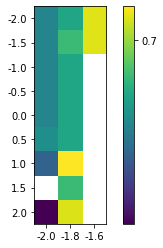

In [109]:
score_grid(dfs,'log_scaling_factor','log_int_scaling_factor','plasticc',dim=18,density=1)